In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
os.environ["CUDA_VISIBLE_DEVICES"]= '6'
np.random.seed(666) #just for reaptable results

#https://github.com/slundberg/shap/blob/9411b68e8057a6c6f3621765b89b24d82bee13d4/notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.ipynb

In [2]:
df1 = pd.read_excel('./proteins_processed.xlsx', index_col = 0)
df2 = pd.read_excel('./Metabolites_processed.xlsx', index_col = 0)
df2 = df2.loc[df1.index]

df = df1.join(df2)
dfx = df[df.columns[2:]]


In [3]:
dfy = df[['Severe']]*1.

In [4]:
tr = df[df['Train_Test'] == 'Train'].index
ts = df[df['Train_Test'] == 'Test'].index

y = pd.get_dummies(dfy['Severe'])[[1,0]]

Y = y.loc[tr].values
X = dfx.loc[tr].values

Y_test = y.loc[ts].values
X_test = dfx.loc[ts].values

mp = loadmap('./results/COV-S.mp')
#mp = mp.fit(var_thr=1e-2, verbose=0)

In [5]:
# 
# len(mp.flist), len(mp.alist)

In [6]:
trainX = mp.batch_transform(X, scale_method = 'minmax')
testX = mp.batch_transform(X_test, scale_method = 'minmax')

print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

# fit the model
clf = AggModel.MultiClassEstimator(epochs = 50,  gpuid = 5, batch_size = 1, conv1_kernel_size = 3,  verbose = 0,) 
clf.fit(trainX, Y)

# save the model for explaination
clf.save_model( './results/model')

# make prediction
y_true = Y_test[:,0]
y_pred = clf.predict(testX)
y_score = clf.predict_proba(testX)[:,0]

res = {'index':ts, 'y_true':y_true, 'y_score':y_score}
dfres = pd.DataFrame(res)

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

y_true = dfres.y_true.values
y_pred = dfres.y_score.values.round()
y_score = dfres.y_score.values


tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

acc = (tp + tn) / sum([tn, fp, fn, tp])

sensitivity = tp / sum([tp, fn])
specificity = tn / sum([tn, fp])

prc_auc = prc_auc_score(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

precision = tp / sum([tp, fp])
recall =  tp / sum([tp, fn]) #equals to sensitivity


res = {
    
       'accuracy':acc, 

       'prc_auc':prc_auc, 
       'roc_auc':roc_auc,

       'sensitivity': sensitivity, 
       'specificity': specificity,

       'precision':precision,
       'recall':recall,

       'F1': 2*precision*sensitivity/(precision+sensitivity)
      }
res

100%|##########| 10/10 [00:00<00:00, 124.48it/s]



 input train and test X shape is (31, 39, 39, 5), (10, 39, 39, 5) 
saving model to ./results/model


{'accuracy': 0.8,
 'prc_auc': 0.9083333333333333,
 'roc_auc': 0.9166666666666667,
 'sensitivity': 1.0,
 'specificity': 0.6666666666666666,
 'precision': 0.6666666666666666,
 'recall': 1.0,
 'F1': 0.8}

In [7]:
from aggmap.AggModel import shapley_explainer, simply_explainer

2021-10-03 10:58:59,647 - INFO - [bidd-aggmap] - calculating feature importance for class 0 ...


100%|##########| 1521/1521 [00:13<00:00, 117.06it/s]

2021-10-03 10:59:12,762 - INFO - [bidd-aggmap] - calculating feature importance for class 1 ...



100%|##########| 1521/1521 [00:00<00:00, 6457.16it/s]


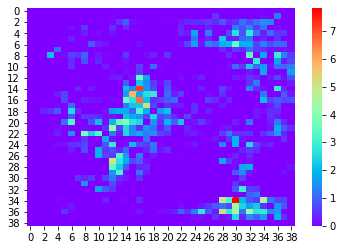

In [8]:
simp_explainer = simply_explainer(clf, mp)
global_imp_simp = simp_explainer.global_explain(clf.X_, clf.y_)
local_imp_simp = simp_explainer.local_explain(clf.X_[[0]], clf.y_[[0]])
sns.heatmap(global_imp_simp.simply_importance_class_1.values.reshape(mp.fmap_shape), cmap = 'rainbow', vmin=0)

In [9]:
shap_explainer = shapley_explainer(clf, mp)
local_imp_shap = shap_explainer.local_explain(clf.X_[[0]])
global_imp_shap = shap_explainer.global_explain(clf.X_)

100%|##########| 1/1 [00:00<00:00, 165.09it/s]



100%|##########| 4648/4648 [00:07<00:00, 605.32it/s]


100%|##########| 4732/4732 [00:05<00:00, 917.46it/s]

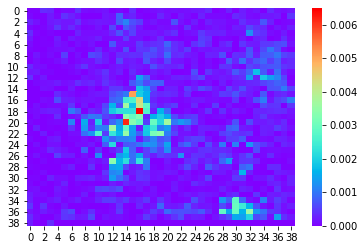

In [10]:
sns.heatmap(global_imp_shap.shapley_importance_class_1.values.reshape(mp.fmap_shape), cmap = 'rainbow')

In [11]:
global_imp_simp[['simply_importance_class_1']].join(global_imp_shap.shapley_importance_class_1).corr()

,simply_importance_class_1,shapley_importance_class_1
simply_importance_class_1,1.000000,0.664866
shapley_importance_class_1,0.664866,1.000000


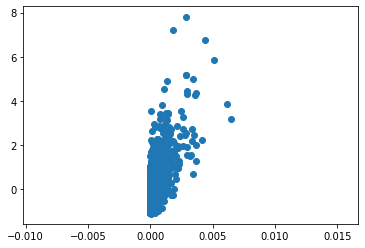

In [12]:
plt.scatter(global_imp_shap.shapley_importance_class_1.tolist(), global_imp_simp.simply_importance_class_1.tolist())

In [13]:
global_imp_shap.shapley_importance_class_1.sort_values(ascending=False).head(30)

P13671                                           0.006494
Q13790                                           0.006172
P01011                                           0.005080
P0DJI8                                           0.004364
P02748                                           0.004140
P12259                                           0.003706
gluconate                                        0.003692
P13987                                           0.003676
bilirubin degradation product, C17H18N2O4 (3)    0.003618
Q06033                                           0.003497
beta-hydroxyisovalerate                          0.003421
8-hydroxyoctanoate                               0.003396
P02763                                           0.003374
P18428                                           0.003334
P00450                                           0.003288
2S,3R-dihydroxybutyrate                          0.003163
bilirubin degradation product, C17H20N2O5 (1)    0.002957
hypoxanthine  

In [14]:
global_imp_simp.simply_importance_class_1.sort_values(ascending=False).head(30)

ribose                                                 7.821433
P05156                                                 7.207454
P0DJI8                                                 6.750235
P01011                                                 5.835989
Q9UK55                                                 5.196821
glycochenodeoxycholate glucuronide (1)                 5.172789
8-hydroxyoctanoate                                     4.983880
picolinate                                             4.924982
tigloylglycine                                         4.548315
hypoxanthine                                           4.470683
P12259                                                 4.341759
bilirubin degradation product, C17H20N2O5 (1)          4.313954
bilirubin degradation product, C17H18N2O4 (3)          4.248605
Q13790                                                 3.875375
P31995                                                 3.804657
P02790                                  